### Assignment 4. Mental Health Disorder Classification 

This assignment is to develop a decision tree model (random forests) to predict mental health disorder classification from a collection of symptoms.  The objective of this study is to determine whether we can develop quantitative analysis that predicts mental health diagnosis, and useful results that can inform practice (without doing all this analysis)
 
This data set is mostly categorical variables, e.g., mood swings (yes/no).  For categorical decision trees can make more intuitive sense since the boundaries separate the different categories.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV  # this is a new method
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance



- Load Data

In [3]:
df = pd.read_csv('cleaned_mental_disorder_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Sadness              120 non-null    object
 1   Euphoric             120 non-null    object
 2   Exhausted            120 non-null    object
 3   Sleep dissorder      120 non-null    object
 4   Mood Swing           120 non-null    object
 5   Suicidal thoughts    120 non-null    object
 6   Anorxia              120 non-null    object
 7   Authority Respect    120 non-null    object
 8   Try-Explanation      120 non-null    object
 9   Aggressive Response  120 non-null    object
 10  Ignore & Move-On     120 non-null    object
 11  Nervous Break-down   120 non-null    object
 12  Admit Mistakes       120 non-null    object
 13  Overthinking         120 non-null    object
 14  Sexual Activity      120 non-null    object
 15  Concentration        120 non-null    object
 16  Optimisi

Every single variable in this data set is categorical!  Lets take a quick look 

In [4]:
# display the first few rows
print("First few rows of the dataset:")
df.head(5)

First few rows of the dataset:


,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
0,Usually,Seldom,Sometimes,Sometimes,YES,YES,NO,NO,YES,NO,NO,YES,YES,YES,3 From 10,3 From 10,4 From 10,Bipolar Type-2
1,Usually,Seldom,Usually,Sometimes,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,4 From 10,2 From 10,5 From 10,Depression
2,Sometimes,Most-Often,Sometimes,Sometimes,YES,NO,NO,NO,YES,YES,NO,YES,YES,NO,6 From 10,5 From 10,7 From 10,Bipolar Type-1
3,Usually,Seldom,Usually,Most-Often,YES,YES,YES,NO,YES,NO,NO,NO,NO,NO,3 From 10,2 From 10,2 From 10,Bipolar Type-2
4,Usually,Usually,Sometimes,Sometimes,NO,NO,NO,NO,NO,NO,NO,YES,YES,YES,5 From 10,5 From 10,6 From 10,Normal


Use the scroll bar to look at all the variables.  
We can see that everything has been encoded as text strings, even potentially numeric variables like Sexual Acitivity, Concentration, and Optimism.  

Because I obsess about these things, I am going to fix the misspelling on two column headers. 

In [5]:
df = df.rename(columns={'Anorxia': 'Anorexia', 'Expert Diagnose':'Expert Diagnosis', 'Sleep dissorder':'Sleep disorder'})


1. Are there any missing values in the data set?  If there are remove those observations from the data. 

In [6]:
df.isna().sum()

Sadness                0
Euphoric               0
Exhausted              0
Sleep disorder         0
Mood Swing             0
Suicidal thoughts      0
Anorexia               0
Authority Respect      0
Try-Explanation        0
Aggressive Response    0
Ignore & Move-On       0
Nervous Break-down     0
Admit Mistakes         0
Overthinking           0
Sexual Activity        0
Concentration          0
Optimisim              0
Expert Diagnosis       0
dtype: int64

Because this is categorical data, it will be useful to understand what are the possible values of each variable.  We can use the unique method to find this 

In [7]:
# check for unique value
for column in df.columns:
    unique_values = df[column].unique()
    print(f"\nUnique values in '{column}':\n{unique_values}")


Unique values in 'Sadness':
['Usually' 'Sometimes' 'Seldom' 'Most-Often']

Unique values in 'Euphoric':
['Seldom' 'Most-Often' 'Usually' 'Sometimes']

Unique values in 'Exhausted':
['Sometimes' 'Usually' 'Seldom' 'Most-Often']

Unique values in 'Sleep disorder':
['Sometimes' 'Most-Often' 'Usually' 'Seldom']

Unique values in 'Mood Swing':
['YES' 'NO']

Unique values in 'Suicidal thoughts':
['YES' 'NO']

Unique values in 'Anorexia':
['NO' 'YES']

Unique values in 'Authority Respect':
['NO' 'YES']

Unique values in 'Try-Explanation':
['YES' 'NO']

Unique values in 'Aggressive Response':
['NO' 'YES']

Unique values in 'Ignore & Move-On':
['NO' 'YES']

Unique values in 'Nervous Break-down':
['YES' 'NO']

Unique values in 'Admit Mistakes':
['YES' 'NO']

Unique values in 'Overthinking':
['YES' 'NO']

Unique values in 'Sexual Activity':
['3 From 10' '4 From 10' '6 From 10' '5 From 10' '7 From 10' '8 From 10'
 '9 From 10' '2 From 10' '1 From 10']

Unique values in 'Concentration':
['3 From 10

- There is of course a brute force approach to encoding this data numerically that could work, but thats throwing out the baby with the bath water. 

- There are 4 types of variables. 
    - 'Expert Diagnosis' has 4 categorical variables that bear no particular relationship.  Since this is the target variable for classification, we can actually leave them as is and it will facilitate making most of the tables and plots. DO NOT ENCODE!
    - 7 variables have 'YES' and 'NO' as the two possibilities.  It would be ideal to encode 'YES' as 1 and 'NO' as 0 
    - 3 variables are encoded as '3 from 10', etc.  This indicates that on a scale of 10 a numeric score of 3 was given.  These should be ideally converted to numeric values 
    - 4 variables have descriptive values, [Seldom' 'Sometimes' 'Usually' ''Most-Often'].   These are actually ordered values, wwith 'Seldom' as the least, and 'Most-Often' as the most.They should be numerically encoded to reflect their relative strength. 

Since we desire to make a careful encoding, using pd.get_dummies will not work that well.  We should instead be specific about the encoding.  Here is an example 

In [8]:
# desired encoding categorical variables

encoder = {'Seldom':1, 'Sometimes':2, 'Usually':3, 'Most-Often':4}
for j in df.columns[0:4]:
    df[j] = df[j].map(encoder)



2. Using similar logic, encode the other predictor variables as numeric quantities.  

In [23]:


encoder = {'YES': 1, 'NO':0} 
for j in df.columns[4:14]: 
    df[j] = df[j].map(encoder)



encoder = {'1 From 10': .1, '2 From 10': .2, '3 From 10':.3, '4 From 10': .4, '5 From 10':.5, '6 From 10': .6, '7 From 10':.7, '8 From 10':.8, '9 From 10':.9, '10 From 10':1.0 }
for j in df.columns[14:17]:
    df[j] = df[j].map(encoder)







In [25]:
df.head(4)


,Sadness,Euphoric,Exhausted,Sleep disorder,Mood Swing,Suicidal thoughts,Anorexia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnosis
0,3,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bipolar Type-2
1,3,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Depression
2,2,4,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bipolar Type-1
3,3,1,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bipolar Type-2


Exploratory Data Analysis - You need to do this to understand your results! 
Since these are all categorical variables, it makes the most sense to use histograms or count plots.  There are a lot of plots to look at.  When you do that, its very useful to come up with a systematic way to label things using colors to help your reader. 

3. Make a plot using sns.countplot that shows the number of patients with each diagnosis.  when you make this plot, choose the `palette` argument carefully, because this will assign each of the diagnosis a different color.  We want to keep that consistent throughout the notebook.  I  control this by setting `hue` = 'Expert Diagnosis' and `palette` = 'bright' but there are other popular palettes.  You can suppress the legend using `legend` = False.  Also take control of the order in which the different diagnosis are presented so they make sense, by provding the `order` as a list of the diagnoses.

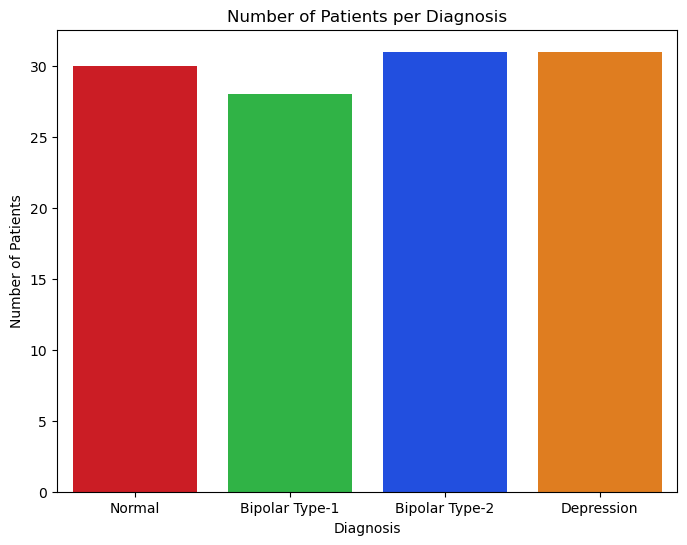

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt


diagnosis_order = ['Normal', 'Bipolar Type-1', 'Bipolar Type-2', 'Depression']

plt.figure(figsize=(8,6))

sns.countplot(
    data=df,
    x='Expert Diagnosis',       
    hue='Expert Diagnosis',     
    palette='bright',          
    order=diagnosis_order      
)


plt.legend([],[], frameon=False)

plt.title("Number of Patients per Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Number of Patients")
plt.show()


Now, plot all the predictors variables as histograms. My call inside a loop lindexed by i ooked like this - 

`sns.histplot(data=df, x=df.columns[i], hue='Expert Diagnosis', hue_order = ['Depression','Bipolar Type-1','Bipolar Type-2','Normal'],multiple="dodge", kde=True, palette="bright",legend=False)`

You dont need a legend here, because the previous plot assigned a color to each diagnosis and I am following the same color scheme here.  

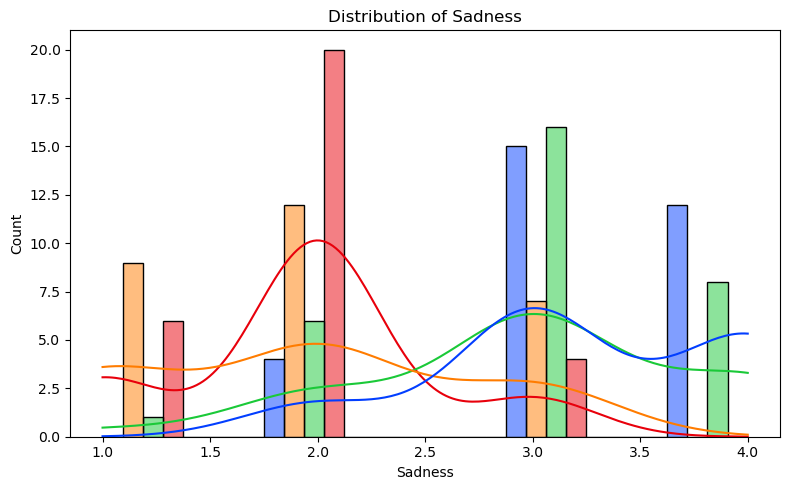

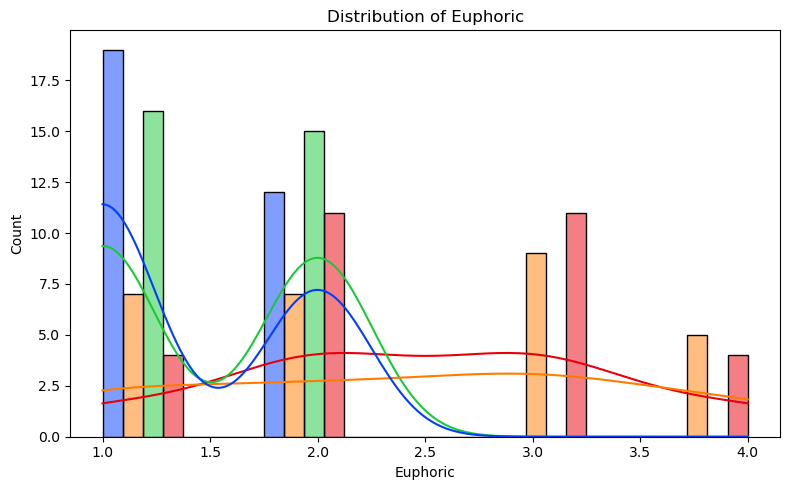

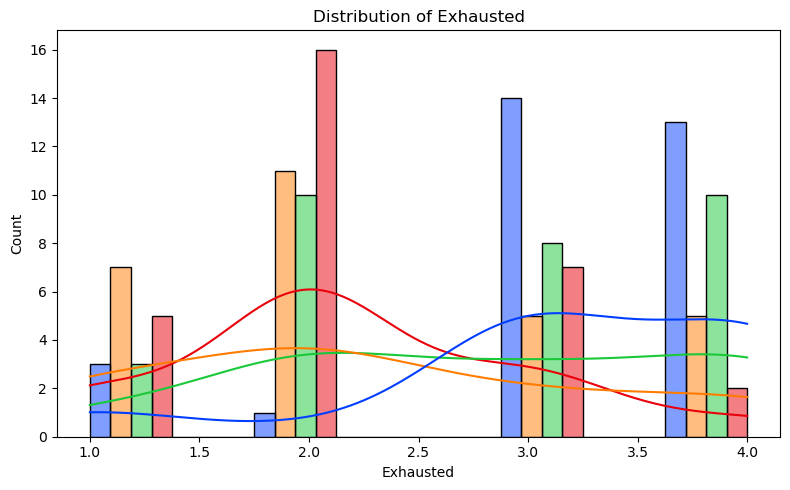

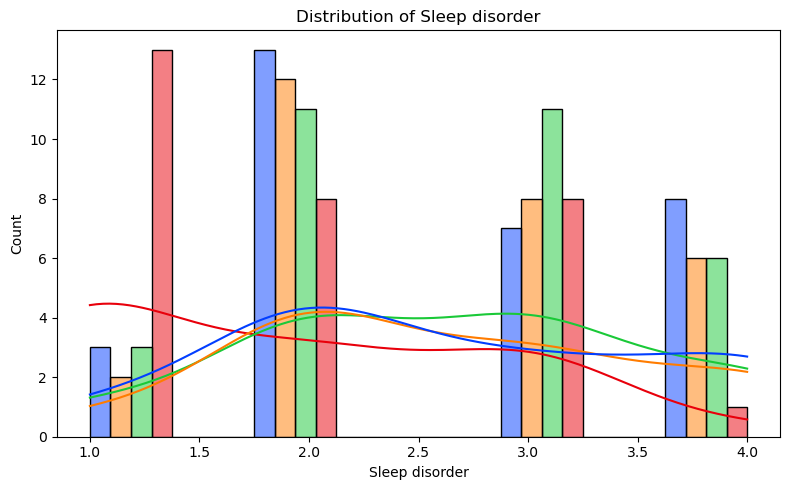

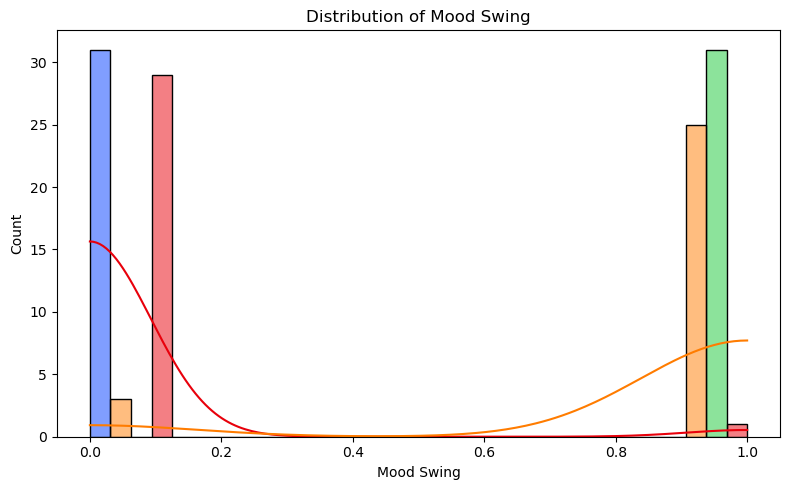

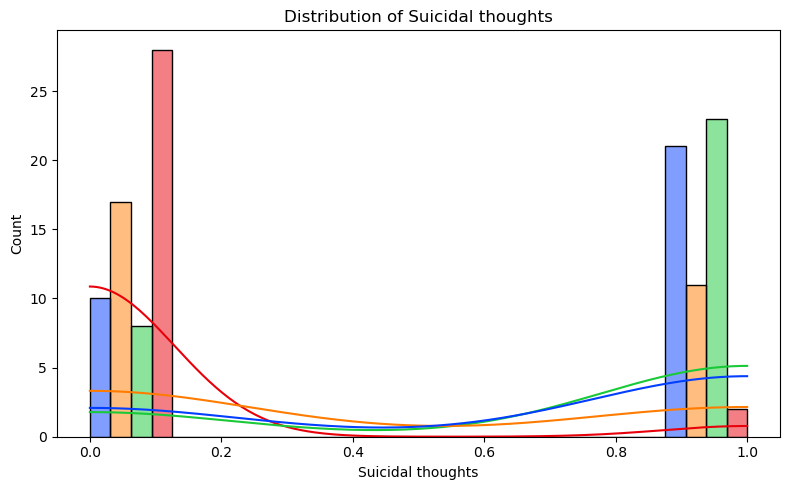

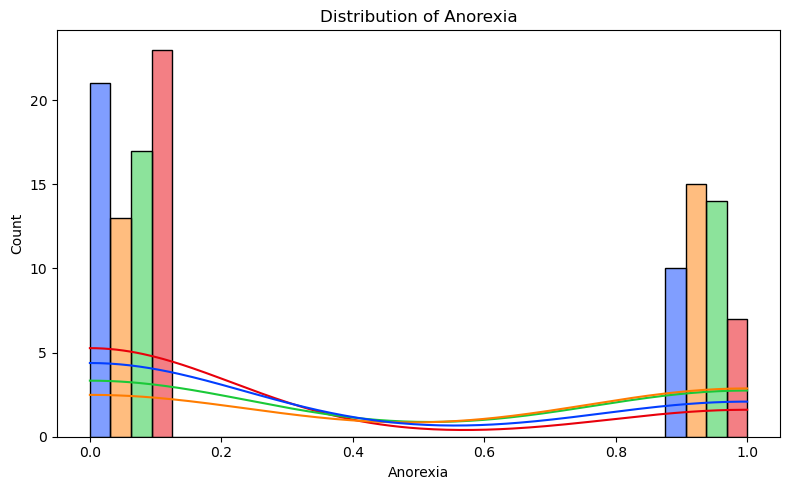

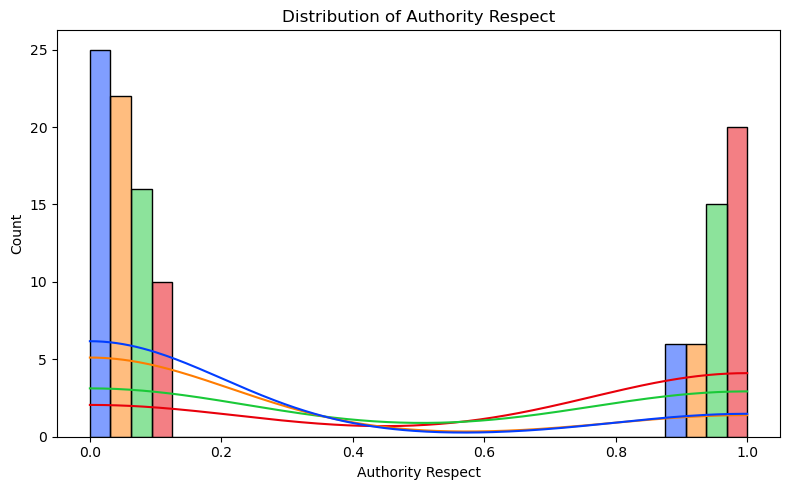

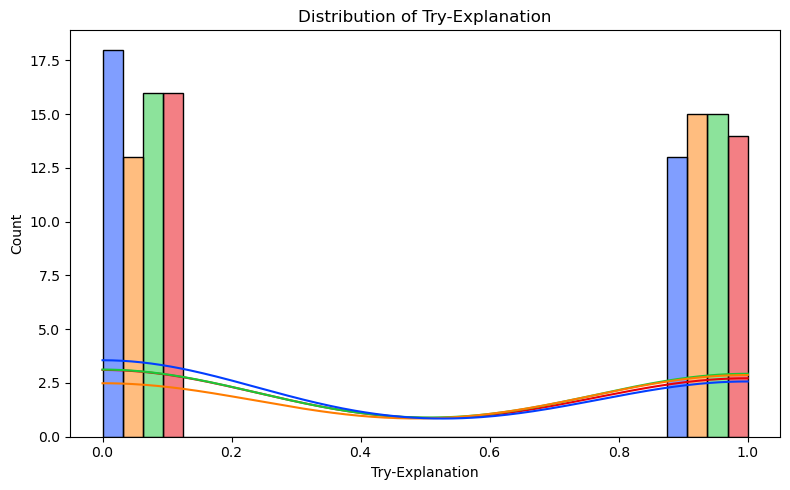

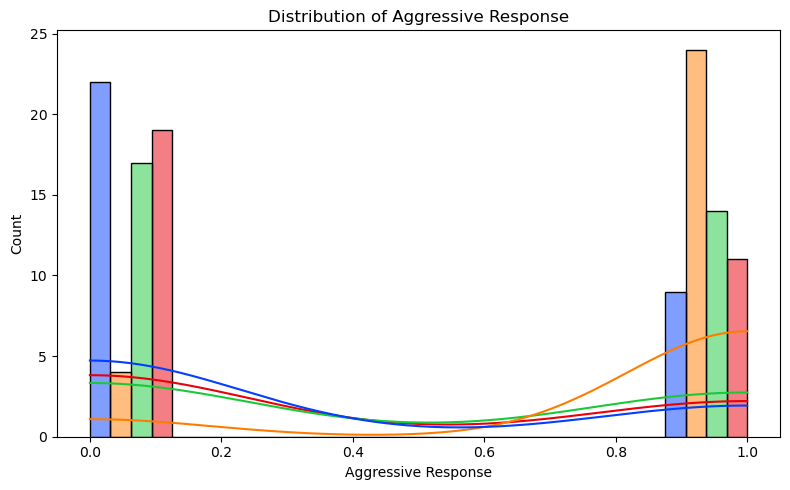

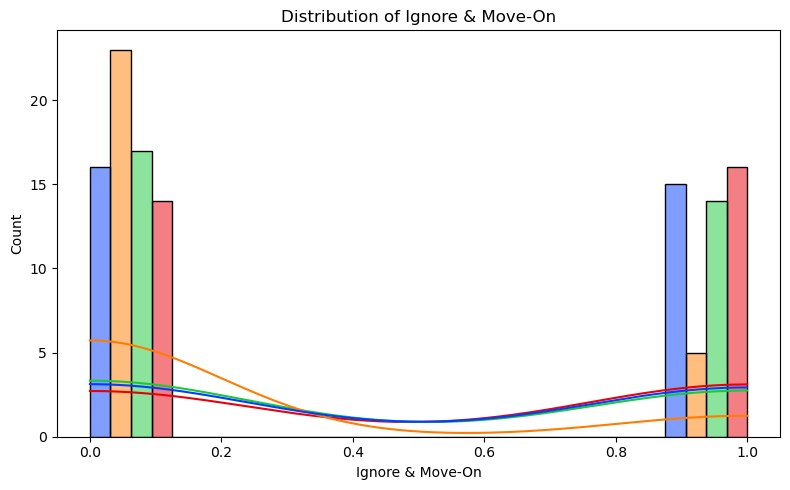

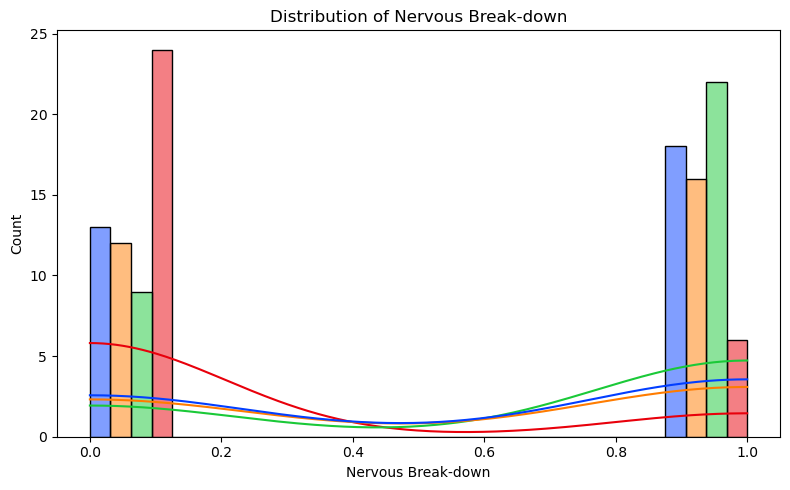

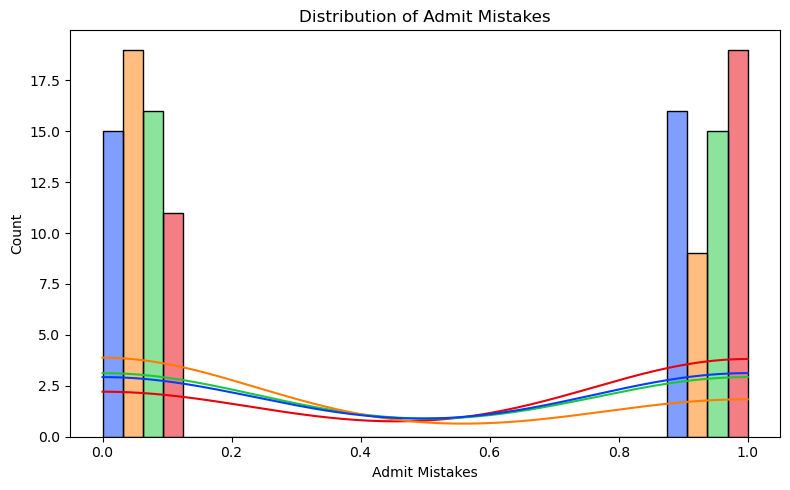

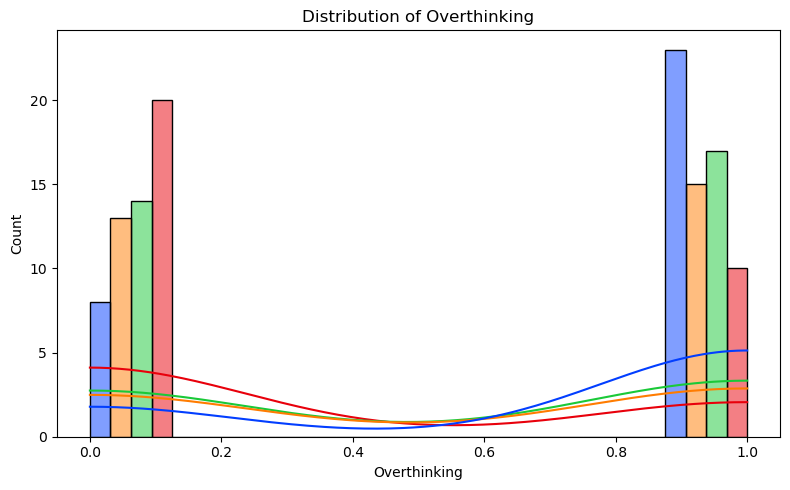

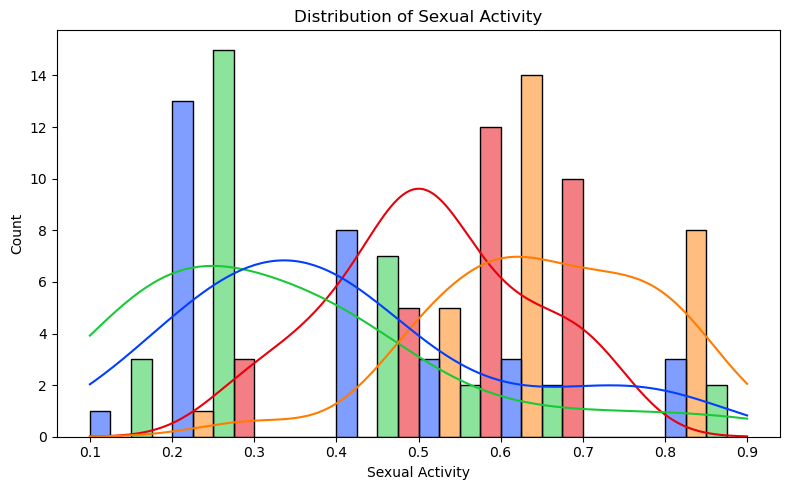

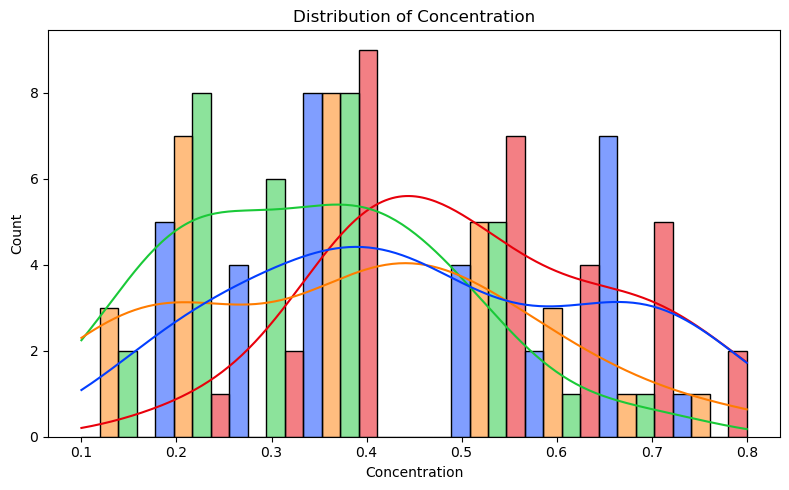

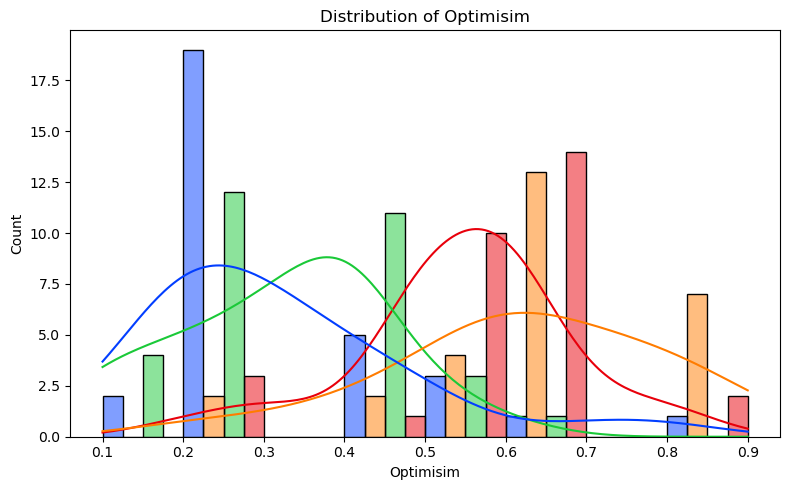

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

diagnosis_order = ['Depression','Bipolar Type-1','Bipolar Type-2','Normal']

predictor_cols = [col for col in df.columns if col != 'Expert Diagnosis']

for col in predictor_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df,
        x=col,                           
        hue='Expert Diagnosis',
        hue_order=diagnosis_order,
        multiple="dodge",
        kde=True,
        palette="bright",
        legend=False
    )
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


4.  Split the data into test and training sets. I put 30% into my test set.  Separate the target 'Expert Diagnosis' as the y variable and all the predictors as X.  
- **Its very important to stratify correctly.**  That is, we want the test data to be balanced in the same way as the training data.  
- If you called the target variable y, then include a parameter `stratify = y` when you split the data 

In [16]:
X = df[predictor_cols]             
y = df['Expert Diagnosis'] 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)
print("Training set distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))



Training set distribution:
Expert Diagnosis
Bipolar Type-2    0.261905
Depression        0.261905
Normal            0.250000
Bipolar Type-1    0.226190
Name: proportion, dtype: float64

Test set distribution:
Expert Diagnosis
Bipolar Type-2    0.25
Bipolar Type-1    0.25
Normal            0.25
Depression        0.25
Name: proportion, dtype: float64


5. Set up a random forest classifiers.  We need to use GridSearchCV to optimize two hyperparameters - `n_estimators`, the number of trees and max_depth.  I used n_estimators ranging from 100 to 400 and max_depth ranging from 1 to 5.  For scoring lets use accuracy.  I usually do 5-fold cross validation by default. Fit the classifier to the training data. 

Report 
    - best max-depth
    - best n_estimators
    - best Accuracy 

Extract the best rf model from your fit.   

In [17]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


rf = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [1, 2, 3, 4, 5]
}


grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1    
)


grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
best_rf

print("Best max_depth:", grid.best_params_['max_depth'])
print("Best n_estimators:", grid.best_params_['n_estimators'])
print("Best Accuracy:", grid.best_score_)


Best max_depth: 3
Best n_estimators: 400
Best Accuracy: 0.9036764705882353


6. Evaluate your classifier by predicting the test data.

Present 

- the accuracy score 
- classification report.  

In the markdown below, write down what the precision and recall values are telling you about hen this model performs well

In [18]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = best_rf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Test Accuracy: 0.8611111111111112
Classification Report:
                 precision    recall  f1-score   support

Bipolar Type-1       0.89      0.89      0.89         9
Bipolar Type-2       0.89      0.89      0.89         9
    Depression       0.82      1.00      0.90         9
        Normal       0.86      0.67      0.75         9

      accuracy                           0.86        36
     macro avg       0.86      0.86      0.86        36
  weighted avg       0.86      0.86      0.86        36



The test accuracy for this model is 0.86 (approximately),therefore, the model correctly interprets/labels 86% of the samples in the set.  This model shows the highest preciison for Bipolar type 1 and type 2, meaning it tends to predict these two diagnoses the most accurately.   The best recall is seen for Depression, so we can assume the model doesn't miss very many true positives and is accounting for all the depression diagnoses. Recall is the lowest in the Normal condition, so lots of people without any diagnoses are being misdiagnosed. Normal cases are being overlooked, and there are a moderate amount of false negatives. 

Comment on accuracy, precision, and recall. 



7. Make a confusion matrix to look at the pattern of misclassification.  When you do this, you will see that it labels the diagnoses as 0,1,2,3.  This is because internally, random forest mapped the conditions onto numeric values.  To find the mapping, look at `.classes_' of your best random forest object. In my case, it looked like this. 

['Bipolar Type-1' 'Bipolar Type-2' 'Depression' 'Normal']

so thats the order of conditions, and you should be able to fix your labels. 


Class mapping: ['Bipolar Type-1' 'Bipolar Type-2' 'Depression' 'Normal']


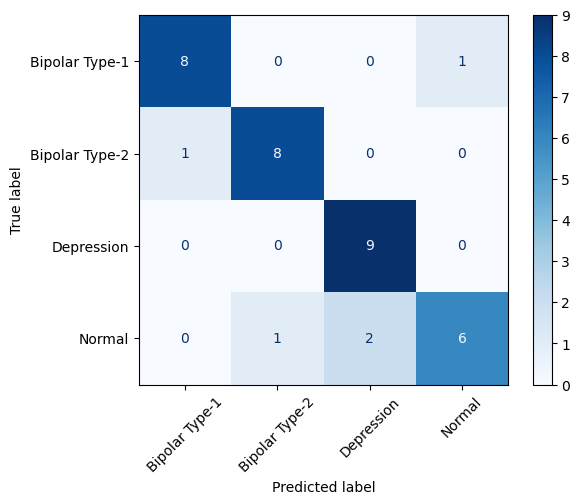

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = best_rf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)


print("Class mapping:", best_rf.classes_)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)




8. To evaluate which predictors were useful for the classifier, use permutation_importance rather than partial dependence.  When we have more than 2 classes, permutation_important becomes harder to interpret as the model considers classifying one versus the rest.  Permutation importance tells us how much accuracy will decline if randomize the variable.  

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd


result = permutation_importance(
    best_rf,      
    X_test,       
    y_test,       
    n_repeats=10, 
    random_state=42,
    scoring='accuracy'
)


importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                Feature  Importance       Std
4            Mood Swing    0.391667  0.085572
14      Sexual Activity    0.100000  0.035573
16            Optimisim    0.077778  0.056656
0               Sadness    0.025000  0.019444
5     Suicidal thoughts    0.013889  0.013889
1              Euphoric    0.011111  0.028328
2             Exhausted    0.008333  0.030556
11   Nervous Break-down    0.005556  0.011111
3        Sleep disorder    0.000000  0.000000
13         Overthinking    0.000000  0.000000
8       Try-Explanation    0.000000  0.000000
6              Anorexia    0.000000  0.000000
10     Ignore & Move-On    0.000000  0.000000
15        Concentration    0.000000  0.000000
12       Admit Mistakes    0.000000  0.000000
9   Aggressive Response   -0.008333  0.012729
7     Authority Respect   -0.019444  0.012729


Exception ignored in: <function ResourceTracker.__del__ at 0x104e61f80>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10aa09f80>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105305f80>
Traceback (most recent call last

Write 1-2 paragraphs that summarizes

1.  what is the data and what is the question being asked of the data. 
2. what the model you made was, and how well the model performed.  What kind of errors if any does it make.  
3. What features of the data were most informative of mental health diagnosis.  
4. Can you provide a simple explanation of how to make a preliminary diagnosis that could be provided to counselors and first responders? 
5. If you had limited space and could only show a few of these figures, which ones would you show? 

1. This is a large dataset with many factors describing different aspects of human behavior. Our aim is to determine the significance and impact of these factors in making various mental health diagnoses. 
2. I made histograms to visually assess the distribution of each diagnosis among all the factors. Another model I made for this dataset was a confusion matrix, which indicated that the data had high precision across all diagnoses, thus, patients were rarely misdiagnosed or under/over diagnosed when they were evaluated upon these factors. Lastly, the permutation model at the tail end of this assignment showed that several of the factors had essentially no importance when it came to diagnosing an individual, which at first confused me, but made sense once I realized that those factors were categorical, and were numerically encoded to either be valued at 1 or 0, (yes or no). 
3. According to the permutation model, mood swings, sexual activity, and optimism are the most informative for a mental health diagnosis.
4. To make a preliminary diagnosis, evaluate the patient's mood swings, sexual activity, and optimism levels since those are clearly important contributors to mental disorders. 
5. If I had limited space, I would only show the confusion matrix and the histograms. The confusion matrix presents the accuracy of diagnoses across the mental disorders, while the histograms depict the diagnoses in relation to the factors of behavior/symptoms.